<a href="https://colab.research.google.com/github/ddooom/object-oriented-programming/blob/master/assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd
from itertools import product
import torch.nn.functional as F
import math

### Load MNIST datasets

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


data_path = './MNIST'
data_test  = MNIST(root = data_path, train= True, download=True, transform= transform)
data_train = MNIST(root = data_path, train= False, download=True, transform= transform)


loader_train = DataLoader(data_train, batch_size=10, num_workers=0, shuffle=False)
loader_test = DataLoader(data_test, batch_size=10, num_workers=0, shuffle=False)

mean = 0.
std = 0.
for images, _ in loader_train:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

for images, _ in loader_test:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader_train.dataset) + len(loader_test.dataset)
std /= len(loader_train.dataset) + len(loader_test.dataset)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,)), 
])


data_path = './MNIST'
data_test  = MNIST(root = data_path, train= True, download=True, transform= transform)
data_train = MNIST(root = data_path, train= False, download=True, transform= transform)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())

the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


### Set Neural Network

In [52]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1 , 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc1 = nn.Linear(4 * 4 * 64, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

In [54]:
a=3

### Set Modeling Function


In [48]:
def train():
    model.train()
    train_loss = 0
    train_acc = 0

    for data, label in mini_batch_train:
        data, label = Variable(data).cuda(), Variable(label).cuda()
        output = model.forward(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(label.data.view_as(pred)).sum()

    lr_sechduler.step()
    
    train_loss /= len(mini_batch_train.dataset)

    return train_loss, train_acc

def test():
    model.eval()
    test_loss = 0
    test_acc = 0
    
    for data, target in mini_batch_test:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = model.forward(data)

        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(mini_batch_test.dataset)

    return test_loss, test_acc

def modeling(epoch):
  train_losses = []
  train_accs = []

  test_losses = []
  test_accs = []

  for epo in range(1, epoch+1):
    train_loss, train_acc = train()
    test_loss, test_acc = test()

    print('Epoch: {} / Train -> Loss : {:.4f}, Accuracy : {:.4f}%)'.format(epo, train_loss, 100. * train_acc / len(mini_batch_train.dataset)))
    print('            Test  -> Loss : {:.4f}, Accuracy : {:.4f}%)'.format(test_loss, 100. * test_acc / len(mini_batch_test.dataset)))
  
    train_losses.append(train_loss)
    train_accs.append(train_acc / len(mini_batch_train.dataset))
    test_losses.append(test_loss)
    test_accs.append(test_acc / len(mini_batch_test.dataset))

  return train_losses, train_accs, test_losses, test_accs

In [53]:
batch_size = [128]
lr = [0.001]
gamma = [0.999]

comb = list(product(batch_size, lr, gamma))
best_acc = {}
history = []
epoc_history = []

for parameter in comb:
  mini_batch_train = DataLoader(data_train, batch_size=parameter[0], shuffle=True)
  mini_batch_test = DataLoader(data_test, batch_size=parameter[0], shuffle=True)

  model = MyModel().cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=parameter[1])
  lr_sechduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=parameter[2])

  train_losses, train_accs, test_losses, test_accs = modeling(50)

  best_acc['batch_size',parameter[0], "learning_rate",parameter[1], 
            "gamme",parameter[2]]=[test_accs.index(max(test_accs)), max(test_accs)]

  history.append([train_losses, train_accs, test_losses, test_accs])
  epoc_history.append(test_accs.index(max(test_accs)))
  best_acc_epoc = test_accs.index(max(test_accs))+1

  print('batch_size : ',parameter[0], "learning_rate : ",parameter[1], "gamme : ",parameter[2])
  print("epoch : ", best_acc_epoc,  "max_test_acc : ", max(test_accs))

Epoch: 1 / Train -> Loss : 0.0039, Accuracy : 85.1100%)
            Test  -> Loss : 0.0015, Accuracy : 94.0733%)
Epoch: 2 / Train -> Loss : 0.0009, Accuracy : 96.6100%)
            Test  -> Loss : 0.0010, Accuracy : 96.3167%)
Epoch: 3 / Train -> Loss : 0.0005, Accuracy : 97.9100%)
            Test  -> Loss : 0.0009, Accuracy : 96.6417%)
Epoch: 4 / Train -> Loss : 0.0004, Accuracy : 98.5500%)
            Test  -> Loss : 0.0007, Accuracy : 97.2600%)
Epoch: 5 / Train -> Loss : 0.0002, Accuracy : 99.0700%)
            Test  -> Loss : 0.0007, Accuracy : 97.4933%)
Epoch: 6 / Train -> Loss : 0.0002, Accuracy : 99.4400%)
            Test  -> Loss : 0.0006, Accuracy : 97.6383%)
Epoch: 7 / Train -> Loss : 0.0001, Accuracy : 99.4700%)
            Test  -> Loss : 0.0006, Accuracy : 97.8350%)
Epoch: 8 / Train -> Loss : 0.0002, Accuracy : 99.3400%)
            Test  -> Loss : 0.0007, Accuracy : 97.5817%)
Epoch: 9 / Train -> Loss : 0.0001, Accuracy : 99.6600%)
            Test  -> Loss : 0.0007, Accu

#Output

### Plot the training and testing losses over epochs

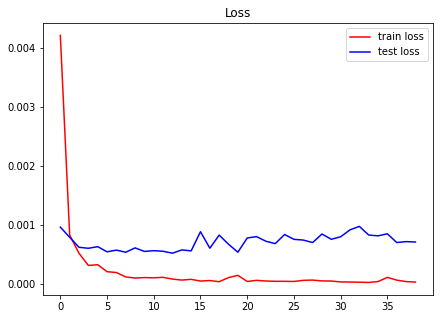

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(best_acc_epoc)), train_losses[0:best_acc_epoc], c='r', label='train loss')
plt.plot(list(range(best_acc_epoc)), test_losses[0:best_acc_epoc], c='b', label='test loss')
plt.title('Loss')
plt.legend()

### Plot the training and testing accuracies over epochs

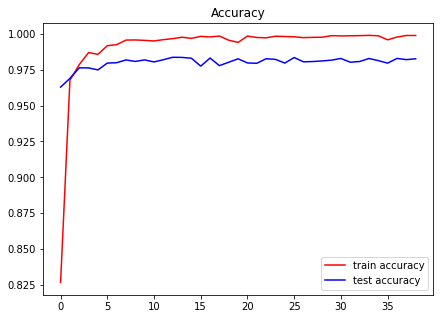

In [13]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(best_acc_epoc)), train_accs[0:best_acc_epoc], c='r', label='train accuracy')
plt.plot(list(range(best_acc_epoc)), test_accs[0:best_acc_epoc], c='b', label='test accuracy')
plt.title('Accuracy')
plt.legend()

### Print the final training and testing losses at convergence

In [28]:
pd.DataFrame([[round(train_losses[best_acc_epoc], 5)],
              [round(test_losses[best_acc_epoc], 5)]], 
             index=['training', 'testing'], columns=['loss'])

,loss
training,0.00001
testing,0.00071


### Print the final training and testing accuracies at convergence

In [29]:
pd.DataFrame([[round(train_accs[best_acc_epoc].item(), 5)],
              [round(test_accs[best_acc_epoc].item(), 5)]], 
             index=['training', 'testing'], columns=['accracy'])

,accracy
training,0.99930
testing,0.98465


### Print the testing accuracies within the last 10 epochs

In [45]:
for i in range(best_acc_epoc - 10, best_acc_epoc):
  print('[epoch = {}] {:.5f}'.format(i+2, test_accs[i+1]))

[epoch = 2] 0.98050
[epoch = 3] 0.98155
[epoch = 4] 0.98000
[epoch = 5] 0.98420
[epoch = 6] 0.98187
[epoch = 7] 0.98323
[epoch = 8] 0.98480
[epoch = 9] 0.98450
[epoch = 10] 0.98520
[epoch = 11] 0.98565


------------------------------------------------------------------

In [33]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),            
            nn.Linear(64, 10),
        )   

    def forward(self,x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out

In [36]:
def train():
    model.train()
    train_loss = 0
    train_acc = 0

    for data, label in mini_batch_train:
        data, label = Variable(data).cuda(), Variable(label).cuda()
        output = model.forward(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(label.data.view_as(pred)).sum()

    
    train_loss /= len(mini_batch_train.dataset)
    lr_sechduler.step(train_loss)
    return train_loss, train_acc

def test():
    model.eval()
    test_loss = 0
    test_acc = 0
    
    for data, target in mini_batch_test:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = model.forward(data)

        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(mini_batch_test.dataset)

    return test_loss, test_acc

def modeling(epoch):
  train_losses = []
  train_accs = []

  test_losses = []
  test_accs = []

  for epo in range(1, epoch+1):
    train_loss, train_acc = train()
    test_loss, test_acc = test()

    print('Epoch: {} / Train -> Loss : {:.4f}, Accuracy : {:.4f}%)'.format(epo, train_loss, 100. * train_acc / len(mini_batch_train.dataset)))
    print('            Test  -> Loss : {:.4f}, Accuracy : {:.4f}%)'.format(test_loss, 100. * test_acc / len(mini_batch_test.dataset)))
  
    train_losses.append(train_loss)
    train_accs.append(train_acc / len(mini_batch_train.dataset))
    test_losses.append(test_loss)
    test_accs.append(test_acc / len(mini_batch_test.dataset))

  return train_losses, train_accs, test_losses, test_accs

In [ ]:
batch_size = [128]
lr = [0.001]
gamma = [0.999]

comb = list(product(batch_size, lr, gamma))
best_acc = {}
history = []
epoc_history = []

for parameter in comb:
  mini_batch_train = DataLoader(data_train, batch_size=parameter[0], shuffle=True)
  mini_batch_test = DataLoader(data_test, batch_size=parameter[0], shuffle=True)

  model = MyModel().cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=parameter[1])
  lr_sechduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min')    

  train_losses, train_accs, test_losses, test_accs = modeling(50)

  best_acc['batch_size',parameter[0], "learning_rate",parameter[1], 
            "gamme",parameter[2]]=[test_accs.index(max(test_accs)), max(test_accs)]

  history.append([train_losses, train_accs, test_losses, test_accs])
  epoc_history.append(test_accs.index(max(test_accs)))
  best_acc_epoc = test_accs.index(max(test_accs))+1

  print('batch_size : ',parameter[0], "learning_rate : ",parameter[1], "gamme : ",parameter[2])
  print("epoch : ", best_acc_epoc,  "max_test_acc : ", max(test_accs))

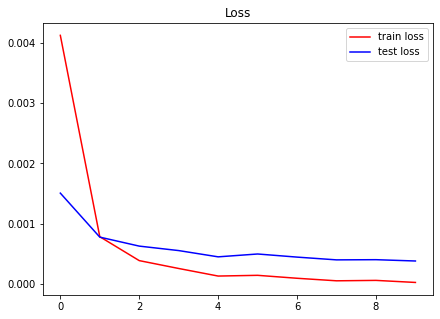

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(best_acc_epoc)), train_losses[0:best_acc_epoc], c='r', label='train loss')
plt.plot(list(range(best_acc_epoc)), test_losses[0:best_acc_epoc], c='b', label='test loss')
plt.title('Loss')
plt.legend()

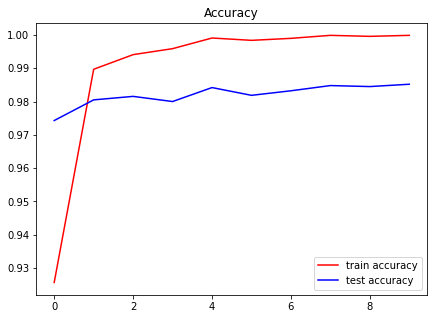

In [39]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(best_acc_epoc)), train_accs[0:best_acc_epoc], c='r', label='train accuracy')
plt.plot(list(range(best_acc_epoc)), test_accs[0:best_acc_epoc], c='b', label='test accuracy')
plt.title('Accuracy')
plt.legend()

In [40]:
pd.DataFrame([[round(train_losses[best_acc_epoc], 5)],
              [round(test_losses[best_acc_epoc], 5)]], 
             index=['training', 'testing'], columns=['loss'])

,loss
training,0.00001
testing,0.00037


In [41]:
pd.DataFrame([[round(train_accs[best_acc_epoc].item(), 5)],
              [round(test_accs[best_acc_epoc].item(), 5)]], 
             index=['training', 'testing'], columns=['accracy'])

,accracy
training,1.00000
testing,0.98565


In [44]:
for i in range(best_acc_epoc - 10, best_acc_epoc):
  print('[epoch = {}] {:.5f}'.format(i+2, test_accs[i+1]))

[epoch = 2] 0.98050
[epoch = 3] 0.98155
[epoch = 4] 0.98000
[epoch = 5] 0.98420
[epoch = 6] 0.98187
[epoch = 7] 0.98323
[epoch = 8] 0.98480
[epoch = 9] 0.98450
[epoch = 10] 0.98520
[epoch = 11] 0.98565
